In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *
from encoding_information.plot_utils import *

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2024-01-09 00:05:59.642611: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 00:06:00.285473: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM
Opened BSCCM


In [2]:


def plot_and_print_analysis(initial_likelihood, optimized_likelihood,
                            samples_initial, samples_optimized, 
                            cov_mat_initial, cov_mat_optimized, patch_size, num_samples):

    print(f'Initial likelihood: {initial_likelihood}')
    print(f'Optimized likelihood: {optimized_likelihood}')


    fig, axs = plt.subplots(2, num_samples, figsize=(num_samples * 3, 4), sharex=True, sharey=True)
    vmin_optimized, vmax_optimized = np.percentile(samples_optimized, .1), np.percentile(samples_optimized, 99.9)
    for i in range(num_samples):
        im1 = axs[0, i].imshow(samples_initial[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized, interpolation='none')
        im2 = axs[1, i].imshow(samples_optimized[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized, interpolation='none')
        axs[0, i].axis('off')
        axs[1, i].axis('off')

    axs[0, 0].set_title('Initial')
    axs[1, 0].set_title('Optimized')

    # add colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im1, cax=cbar_ax)
    cbar_ax.set_ylabel('Photons')

    sample_size = samples_optimized.shape[1] * samples_optimized.shape[2]
    fig.suptitle(f'Sample size: {sample_size}, patch_size: {patch_size}')

    # plot eignevalues of different cov mats
    eig_vals_initial = np.linalg.eigvalsh(cov_mat_initial)
    eig_vals_optimized = np.linalg.eigvalsh(cov_mat_optimized)

    fig2, axs = plt.subplots(1, 1, figsize=(4, 4))
    axs.semilogy(eig_vals_initial, 'o-', label='initial')
    axs.semilogy(eig_vals_optimized, 'o-', label='optimized')
    axs.legend()

    clear_spines(axs)
    axs.set_xlabel('Eigenvalue index')
    axs.set_ylabel('Eigenvalue')
    return fig, fig2

In [3]:
# load images, extract patches, and compute cov mats
edge_crop = 24
patch_size = 10
num_images = 200
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0, verbose=True)

num_patches = num_images 
seed = 10 # this seed gives a bad initial fit
patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed, verbose=True)


100%|██████████| 200/200 [00:02<00:00, 99.40it/s] 


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/image_distribution_models.py:204: UserWarning: Number of validation samples must be less than the number of training samples. Using 20 validation samples instead.
  warnings.warn(f'Number of validation samples must be less than the number of training samples. Using {num_val_samples} validation samples instead.')
2024-01-09 00:06:27.273307: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 26584.41


Epoch 1: 100%|██████████| 1/1 [00:03<00:00,  3.34s/it]


Epoch 1: validation NLL: 23470.95


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 53.31it/s]


Epoch 2: validation NLL: 4202.35


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 57.64it/s]


Epoch 3: validation NLL: 5.50


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 57.22it/s]


Epoch 4: validation NLL: 5.47


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 56.02it/s]


Epoch 5: validation NLL: 5.46


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 55.34it/s]


Epoch 6: validation NLL: 5.45


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 55.83it/s]


Epoch 7: validation NLL: 5.45


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 63.97it/s]


Epoch 8: validation NLL: 5.45


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 65.13it/s]


Epoch 9: validation NLL: 5.45


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s]


Epoch 10: validation NLL: 5.44


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 65.09it/s]


Epoch 11: validation NLL: 5.44


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 64.02it/s]


Epoch 12: validation NLL: 5.44


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 62.40it/s]


Epoch 13: validation NLL: 5.44


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 60.93it/s]


Epoch 14: validation NLL: 5.44


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 62.30it/s]


Epoch 15: validation NLL: 5.44


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 63.28it/s]


Epoch 16: validation NLL: 5.44


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 63.25it/s]


Epoch 17: validation NLL: 5.44


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 63.26it/s]


Epoch 18: validation NLL: 5.44


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 63.15it/s]


Epoch 19: validation NLL: 5.44


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 57.94it/s]


Epoch 20: validation NLL: 5.44


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 58.22it/s]


Epoch 21: validation NLL: 5.44


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 59.54it/s]


Epoch 22: validation NLL: 5.44


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 60.55it/s]


Epoch 23: validation NLL: 5.44


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 60.56it/s]


Epoch 24: validation NLL: 5.44


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 60.18it/s]


Epoch 25: validation NLL: 5.44


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 58.60it/s]


Epoch 26: validation NLL: 5.44


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 62.82it/s]


Epoch 27: validation NLL: 5.44


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 61.06it/s]


Epoch 28: validation NLL: 5.44


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 56.92it/s]


Epoch 29: validation NLL: 5.44


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 63.03it/s]


Epoch 30: validation NLL: 5.44


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 58.28it/s]


Epoch 31: validation NLL: 5.44


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 57.76it/s]


Epoch 32: validation NLL: 5.44


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 61.33it/s]


Epoch 33: validation NLL: 5.44


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 63.52it/s]


Epoch 34: validation NLL: 5.44


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 62.16it/s]


Epoch 35: validation NLL: 5.44


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 63.47it/s]


Epoch 36: validation NLL: 5.44


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 61.20it/s]


Epoch 37: validation NLL: 5.44


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 63.62it/s]


Epoch 38: validation NLL: 5.44


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 61.61it/s]


Epoch 39: validation NLL: 5.44


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 60.07it/s]


Epoch 40: validation NLL: 5.44


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 64.67it/s]


Epoch 41: validation NLL: 5.44


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 62.98it/s]


Epoch 42: validation NLL: 5.44


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 63.31it/s]


Epoch 43: validation NLL: 5.44


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 63.81it/s]


Epoch 44: validation NLL: 5.44


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 61.39it/s]


Epoch 45: validation NLL: 5.44


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 63.65it/s]


Epoch 46: validation NLL: 5.44


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 65.23it/s]


Epoch 47: validation NLL: 5.44


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 62.79it/s]


Epoch 48: validation NLL: 5.44


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 61.69it/s]


Epoch 49: validation NLL: 5.44


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 63.09it/s]


Epoch 50: validation NLL: 5.44


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 63.65it/s]


Epoch 51: validation NLL: 5.44


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 61.21it/s]


Epoch 52: validation NLL: 5.44


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 63.50it/s]


Epoch 53: validation NLL: 5.44


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 59.23it/s]


Epoch 54: validation NLL: 5.44


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 64.94it/s]


Epoch 55: validation NLL: 5.44


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 60.97it/s]


Epoch 56: validation NLL: 5.44


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 61.10it/s]


Epoch 57: validation NLL: 5.44


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 63.62it/s]


Epoch 58: validation NLL: 5.44


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 63.03it/s]


Epoch 59: validation NLL: 5.44


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 61.82it/s]


Epoch 60: validation NLL: 5.44


Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 63.56it/s]


Epoch 61: validation NLL: 5.44


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 63.04it/s]


Epoch 62: validation NLL: 5.44


Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 62.59it/s]


Epoch 63: validation NLL: 5.44


Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 61.69it/s]


Epoch 64: validation NLL: 5.44


Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 61.87it/s]


Epoch 65: validation NLL: 5.44


Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 61.23it/s]


Epoch 66: validation NLL: 5.44


Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 64.57it/s]


Epoch 67: validation NLL: 5.44


Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 64.04it/s]


Epoch 68: validation NLL: 5.44


Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 62.72it/s]


Epoch 69: validation NLL: 5.44


Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 64.06it/s]


Epoch 70: validation NLL: 5.44


Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 65.32it/s]


Epoch 71: validation NLL: 5.44


Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 62.64it/s]


Epoch 72: validation NLL: 5.44


Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 63.37it/s]


Epoch 73: validation NLL: 5.44


Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 63.71it/s]


Epoch 74: validation NLL: 5.44


Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 62.88it/s]


Epoch 75: validation NLL: 5.44


Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 64.05it/s]


Epoch 76: validation NLL: 5.44


Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 62.40it/s]


Epoch 77: validation NLL: 5.44


Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 63.53it/s]


Epoch 78: validation NLL: 5.44


Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 61.76it/s]


Epoch 79: validation NLL: 5.44


Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 63.52it/s]


Epoch 80: validation NLL: 5.44


Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 59.93it/s]


Epoch 81: validation NLL: 5.44


Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 54.83it/s]


Epoch 82: validation NLL: 5.44


Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 58.78it/s]


Epoch 83: validation NLL: 5.44


Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 58.56it/s]


Epoch 84: validation NLL: 5.44


Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 63.59it/s]


Epoch 85: validation NLL: 5.44


Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 56.97it/s]


Epoch 86: validation NLL: 5.44


Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 61.75it/s]


Epoch 87: validation NLL: 5.44


Epoch 88: 100%|██████████| 1/1 [00:00<00:00, 61.63it/s]


Epoch 88: validation NLL: 5.44


Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 58.40it/s]


Epoch 89: validation NLL: 5.44


Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 57.95it/s]


Epoch 90: validation NLL: 5.44


Epoch 91: 100%|██████████| 1/1 [00:00<00:00, 61.13it/s]


Epoch 91: validation NLL: 5.44


Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 57.26it/s]


Epoch 92: validation NLL: 5.44


Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 61.43it/s]


Epoch 93: validation NLL: 5.44


Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 59.60it/s]


Epoch 94: validation NLL: 5.44


Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 58.64it/s]


Epoch 95: validation NLL: 5.44


Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 61.73it/s]


Epoch 96: validation NLL: 5.44


Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 60.86it/s]


Epoch 97: validation NLL: 5.44


Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 56.52it/s]


Epoch 98: validation NLL: 5.44


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 63.19it/s]


Epoch 99: validation NLL: 5.44


Epoch 100: 100%|██████████| 1/1 [00:00<00:00, 57.70it/s]


Epoch 100: validation NLL: 5.44


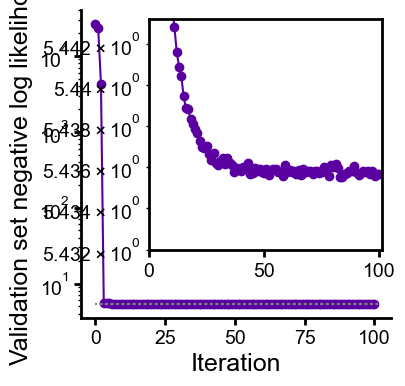

In [4]:
from encoding_information.models.gaussian_process import StationaryGaussianProcess

gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)
val_loss_history = gp.fit(patches, num_val_samples=1000, max_epochs=100, patience=30, verbose=True)
plot_optimization_loss_history(val_loss_history)
plt.gcf().savefig('/home/hpinkard_waller/figures/mi_estimation/gp_optimization_hist.pdf', transparent=True)


## Show the covariance matrix

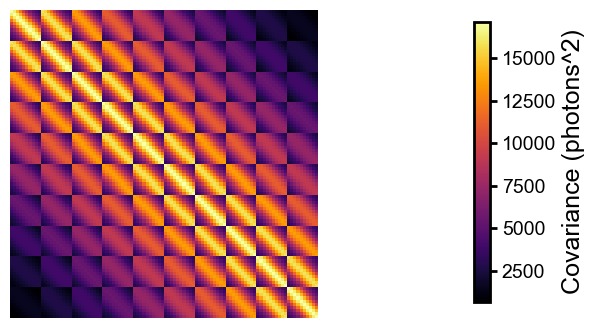

In [11]:
cov_mat = gp.get_cov_mat()

fig, axs = plt.subplots(1, 1, figsize=(8, 4))
im = axs.imshow(cov_mat, cmap='inferno', interpolation='none')
axs.set_axis_off()

# make a colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Covariance (photons^2)')

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/example_cov_mat.pdf', transparent=True)


precomputing masks and variances: 100%|██████████| 40/40 [01:01<00:00,  1.53s/it]


generating stationary gaussian process samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 52.63it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 100.49it/s]
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/image_distribution_models.py:204: UserWarning: Number of validation samples must be less than the number of training samples. Using 20 validation samples instead.
  warnings.warn(f'Number of validation samples must be less than the number of training samples. Using {num_val_samples} validation samples instead.')


Initial validation NLL: 26583.35


Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


Epoch 1: validation NLL: 23577.91


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 45.15it/s]


Epoch 2: validation NLL: 4192.84


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 40.72it/s]


Epoch 3: validation NLL: 5.50


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 39.85it/s]


Epoch 4: validation NLL: 5.47


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 41.17it/s]


Epoch 5: validation NLL: 5.46


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 41.16it/s]

Epoch 6: validation NLL: 5.45



Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]


Epoch 7: validation NLL: 5.45


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 47.74it/s]


Epoch 8: validation NLL: 5.45


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 43.80it/s]


Epoch 9: validation NLL: 5.45


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 39.70it/s]


Epoch 10: validation NLL: 5.44


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 39.60it/s]


Epoch 11: validation NLL: 5.44


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 41.43it/s]


Epoch 12: validation NLL: 5.44


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 46.25it/s]


Epoch 13: validation NLL: 5.44


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s]


Epoch 14: validation NLL: 5.44


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 39.84it/s]


Epoch 15: validation NLL: 5.44


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 39.83it/s]


Epoch 16: validation NLL: 5.44


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 42.61it/s]


Epoch 17: validation NLL: 5.44


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 39.61it/s]


Epoch 18: validation NLL: 5.44


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 49.51it/s]


Epoch 19: validation NLL: 5.44


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]


Epoch 20: validation NLL: 5.44


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 40.60it/s]


Epoch 21: validation NLL: 5.44


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 39.14it/s]


Epoch 22: validation NLL: 5.44


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 40.24it/s]


Epoch 23: validation NLL: 5.44


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 43.77it/s]


Epoch 24: validation NLL: 5.44


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 40.46it/s]


Epoch 25: validation NLL: 5.44


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 39.41it/s]


Epoch 26: validation NLL: 5.44


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 46.32it/s]


Epoch 27: validation NLL: 5.44


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 40.30it/s]


Epoch 28: validation NLL: 5.44


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 40.84it/s]


Epoch 29: validation NLL: 5.44


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 43.61it/s]


Epoch 30: validation NLL: 5.44


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 37.89it/s]


Epoch 31: validation NLL: 5.44


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]


Epoch 32: validation NLL: 5.44


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 39.84it/s]


Epoch 33: validation NLL: 5.44


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


Epoch 34: validation NLL: 5.44


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 46.51it/s]


Epoch 35: validation NLL: 5.44


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 44.35it/s]


Epoch 36: validation NLL: 5.44


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]


Epoch 37: validation NLL: 5.44


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 43.19it/s]


Epoch 38: validation NLL: 5.44


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 40.16it/s]


Epoch 39: validation NLL: 5.44


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 42.95it/s]


Epoch 40: validation NLL: 5.44


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 39.41it/s]


Epoch 41: validation NLL: 5.44


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 40.64it/s]


Epoch 42: validation NLL: 5.44


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 41.47it/s]


Epoch 43: validation NLL: 5.44


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 39.49it/s]


Epoch 44: validation NLL: 5.44


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 48.59it/s]


Epoch 45: validation NLL: 5.44


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 52.14it/s]


Epoch 46: validation NLL: 5.44


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]


Epoch 47: validation NLL: 5.44


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 46.49it/s]


Epoch 48: validation NLL: 5.44


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


Epoch 49: validation NLL: 5.44


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 42.61it/s]


Epoch 50: validation NLL: 5.44


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 41.51it/s]


Epoch 51: validation NLL: 5.44


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 40.20it/s]


Epoch 52: validation NLL: 5.44


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 46.34it/s]


Epoch 53: validation NLL: 5.44


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 46.76it/s]


Epoch 54: validation NLL: 5.44


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 46.00it/s]


Epoch 55: validation NLL: 5.44


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]


Epoch 56: validation NLL: 5.44


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 38.52it/s]


Epoch 57: validation NLL: 5.44


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 42.49it/s]


Epoch 58: validation NLL: 5.44


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 42.84it/s]


Epoch 59: validation NLL: 5.44


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]


Epoch 60: validation NLL: 5.44


Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 40.21it/s]


Epoch 61: validation NLL: 5.44


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 42.98it/s]


Epoch 62: validation NLL: 5.44


Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 44.06it/s]


Epoch 63: validation NLL: 5.44


Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 46.29it/s]


Epoch 64: validation NLL: 5.44


Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 39.26it/s]


Epoch 65: validation NLL: 5.44


Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 39.39it/s]


Epoch 66: validation NLL: 5.44


Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 46.54it/s]


Epoch 67: validation NLL: 5.44


Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 46.12it/s]


Epoch 68: validation NLL: 5.44


Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 42.18it/s]


Epoch 69: validation NLL: 5.44


Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 39.58it/s]


Epoch 70: validation NLL: 5.44


Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 45.27it/s]


Epoch 71: validation NLL: 5.44


Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 60.96it/s]


Epoch 72: validation NLL: 5.44


Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 51.38it/s]


Epoch 73: validation NLL: 5.44


Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 39.68it/s]


Epoch 74: validation NLL: 5.44


Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 46.06it/s]


Epoch 75: validation NLL: 5.44


Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]


Epoch 76: validation NLL: 5.44


Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 44.94it/s]


Epoch 77: validation NLL: 5.44


Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 39.94it/s]


Epoch 78: validation NLL: 5.44


Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 40.55it/s]


Epoch 79: validation NLL: 5.44


Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 40.57it/s]


Epoch 80: validation NLL: 5.44


Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 38.73it/s]


Epoch 81: validation NLL: 5.44


Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 43.23it/s]


Epoch 82: validation NLL: 5.44


Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 40.88it/s]


Epoch 83: validation NLL: 5.44


precomputing masks and variances: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


generating stationary gaussian process samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 109.37it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 173.71it/s]


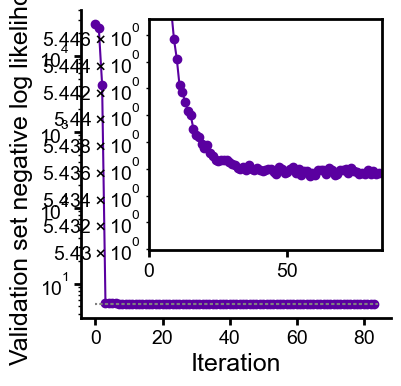

In [5]:
sample_shape = 40
num_samples = 8

gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)

samples_initial = gp.generate_samples(num_samples=num_samples, sample_shape=sample_shape, seed=None)
nll_initial = gp.compute_negative_log_likelihood(test_patches)
cov_mat_initial = gp.get_cov_mat()

# fit it with early stopping
val_loss_history = gp.fit(patches, num_val_samples=1000, max_epochs=100, patience=25, verbose=True)
samples_optimized = gp.generate_samples(num_samples=num_samples, sample_shape=sample_shape, seed=None)
nll_optimized = gp.compute_negative_log_likelihood(test_patches)
cov_mat_optimized = gp.get_cov_mat()

plot_optimization_loss_history(val_loss_history)

Initial likelihood: 30773.65384590627
Optimized likelihood: 5.43257239685654


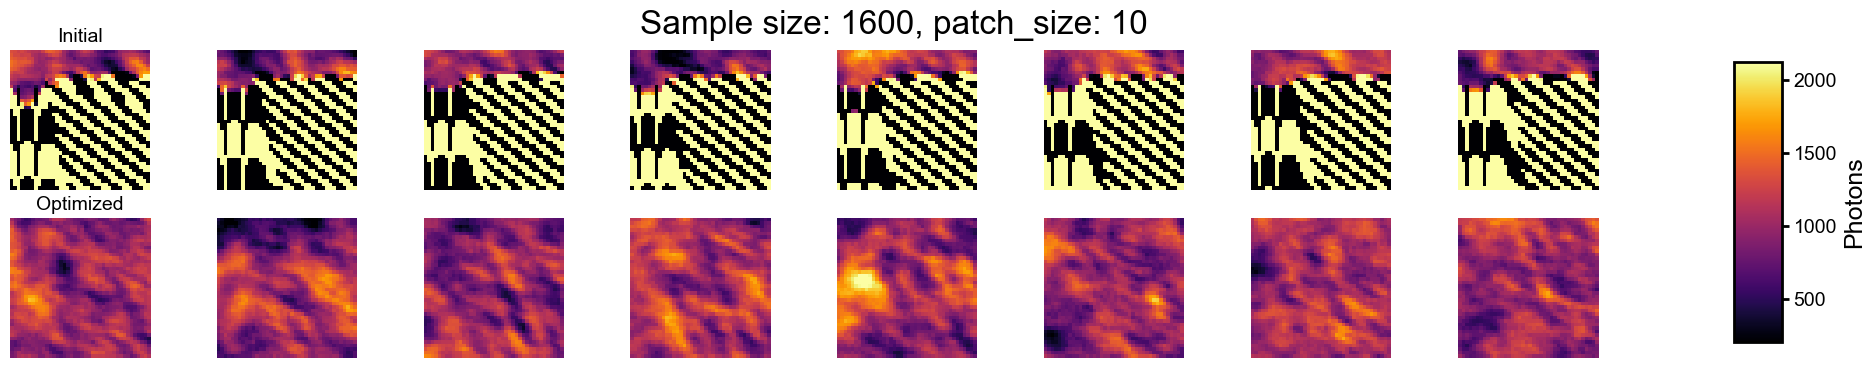

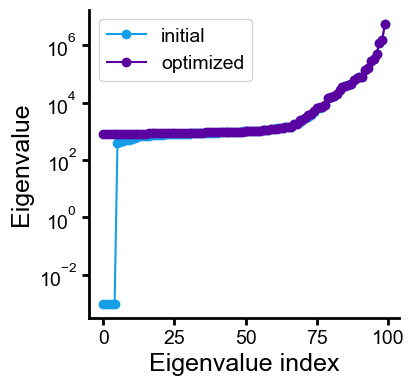

In [6]:

fig1, fig2 = plot_and_print_analysis(nll_initial, nll_optimized,
                            samples_initial, samples_optimized,
                            cov_mat_initial, cov_mat_optimized, patch_size, num_samples)
fig1.savefig('/home/hpinkard_waller/figures/mi_estimation/gp_example_samples.pdf', transparent=True)
fig2.savefig('/home/hpinkard_waller/figures/mi_estimation/gp_example_eigvals.pdf', transparent=True)

## Does DPC produce the same artifacts? 

In [22]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 20000
channel = 'DPC_Right'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0, verbose=True)

num_patches = 10000 
seed = 10 # this seed gives a bad initial fit
patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed, verbose=True)

100%|██████████| 10000/10000 [01:55<00:00, 86.57it/s]


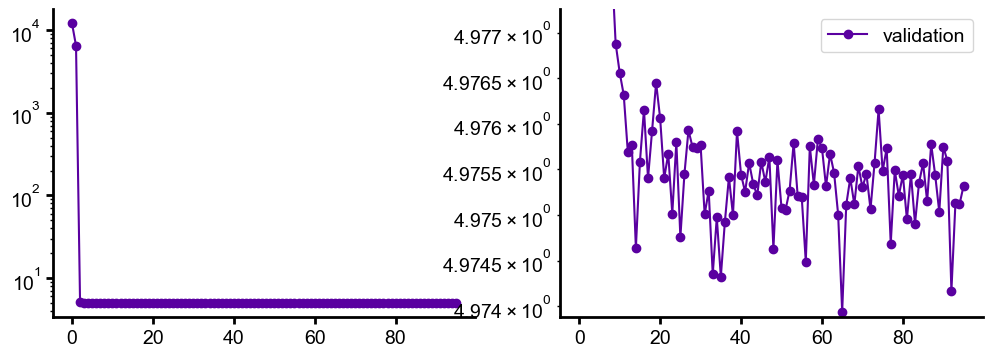

In [23]:

gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)
val_loss_history = gp.fit(patches, num_val_samples=1000, max_epochs=1000, patience=30, verbose=False)
plot_optimization_loss_history(val_loss_history)

precomputing masks and variances:   0%|          | 0/40 [00:00<?, ?it/s]

precomputing masks and variances: 100%|██████████| 40/40 [00:37<00:00,  1.08it/s]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 175.16it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 40/40 [00:38<00:00,  1.05it/s]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 190.76it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 168.52it/s]


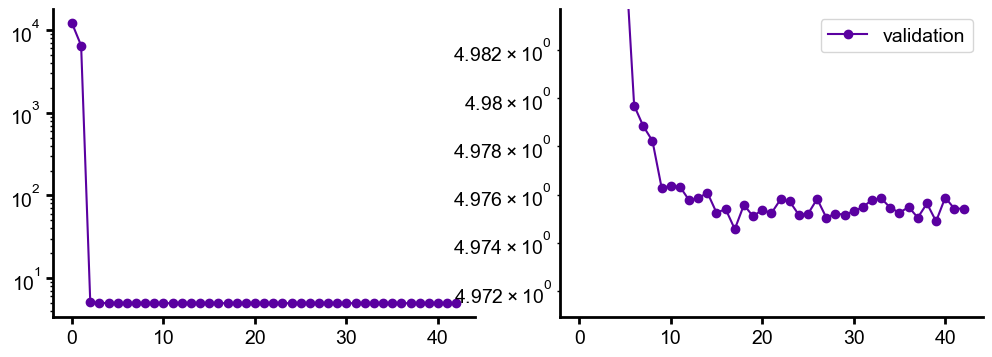

In [24]:
sample_size = 40
num_samples = 8

gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)

samples_initial = gp.generate_samples(num_samples=num_samples, sample_size=sample_size, seed=None)
nll_initial = gp.compute_negative_log_likelihood(test_patches)
cov_mat_initial = gp.get_cov_mat()

# fit it with early stopping
val_loss_history = gp.fit(patches, num_val_samples=1000, max_epochs=1000, patience=25, verbose=False)
samples_optimized = gp.generate_samples(num_samples=num_samples, sample_size=sample_size, seed=None)
nll_optimized = gp.compute_negative_log_likelihood(test_patches)
cov_mat_optimized = gp.get_cov_mat()

plot_optimization_loss_history(val_loss_history)

Initial likelihood: 11751.271064049566
Optimized likelihood: 4.965953932238841


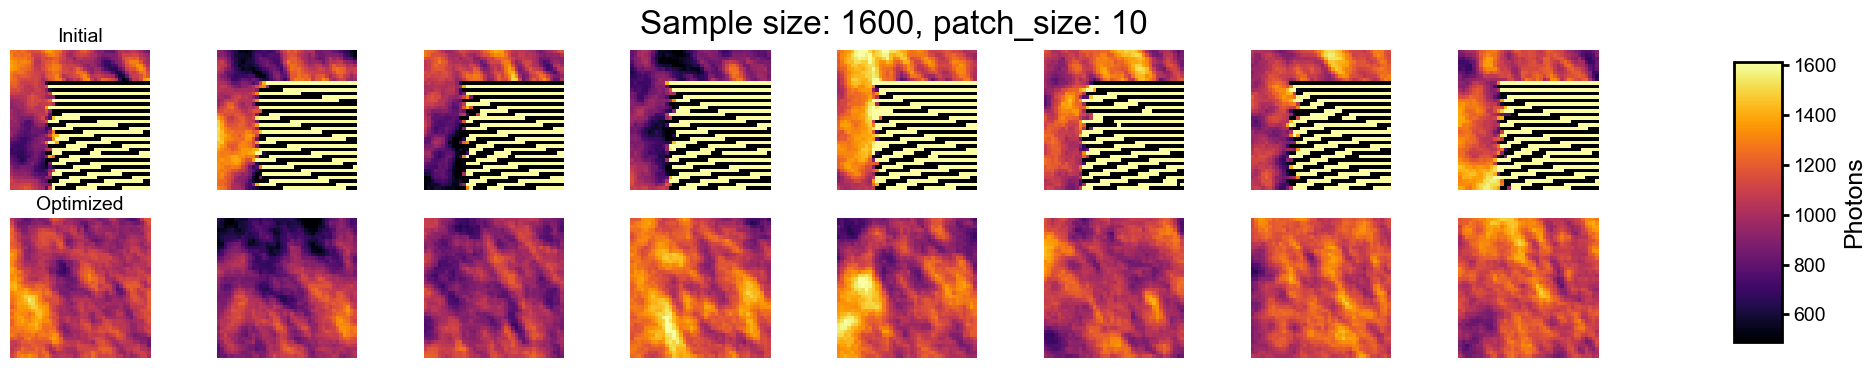

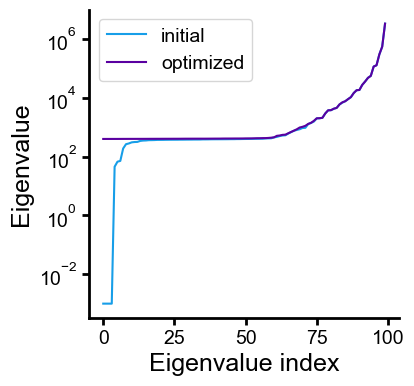

In [25]:
plot_and_print_analysis(nll_initial, nll_optimized,
                            samples_initial, samples_optimized,
                            cov_mat_initial, cov_mat_optimized, patch_size, num_samples)

## Can you generate an even bigger patch?

In [26]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 20000
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)

num_patches = 10000 
seed = 10 # this seed gives a bad initial fit
patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)


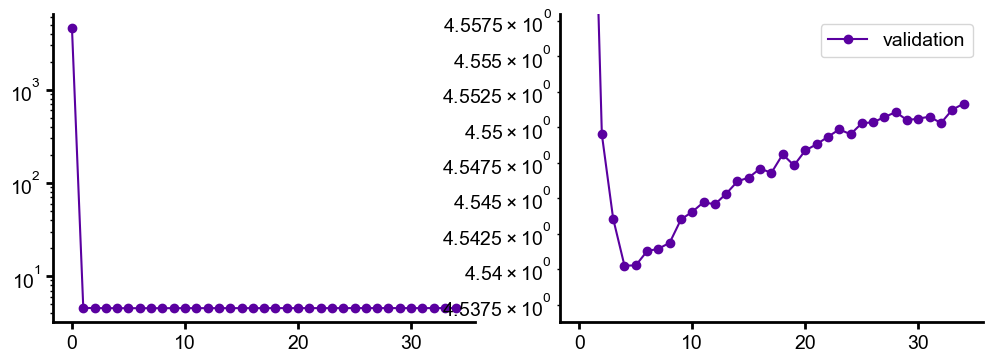

In [27]:

gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)
val_loss_history = gp.fit(patches, num_val_samples=1000, max_epochs=1000, patience=30, verbose=False)
plot_optimization_loss_history(val_loss_history)

precomputing masks and variances: 100%|██████████| 100/100 [04:31<00:00,  2.72s/it]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 189.32it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 100/100 [04:10<00:00,  2.50s/it]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 199.26it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 194.34it/s]


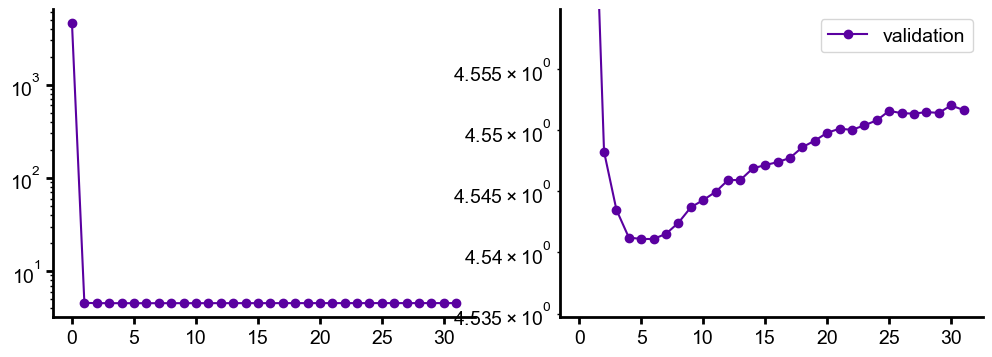

In [29]:
sample_size = 100
num_samples = 8

gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)

samples_initial = gp.generate_samples(num_samples=num_samples, sample_size=sample_size, seed=None)
nll_initial = gp.compute_negative_log_likelihood(test_patches)
cov_mat_initial = gp.get_cov_mat()

# fit it with early stopping
val_loss_history = gp.fit(patches, num_val_samples=1000, max_epochs=1000, patience=25, verbose=False)
samples_optimized = gp.generate_samples(num_samples=num_samples, sample_size=sample_size, seed=None)
nll_optimized = gp.compute_negative_log_likelihood(test_patches)
cov_mat_optimized = gp.get_cov_mat()

plot_optimization_loss_history(val_loss_history)

Initial likelihood: 4671.057957715011
Optimized likelihood: 4.554584112411551


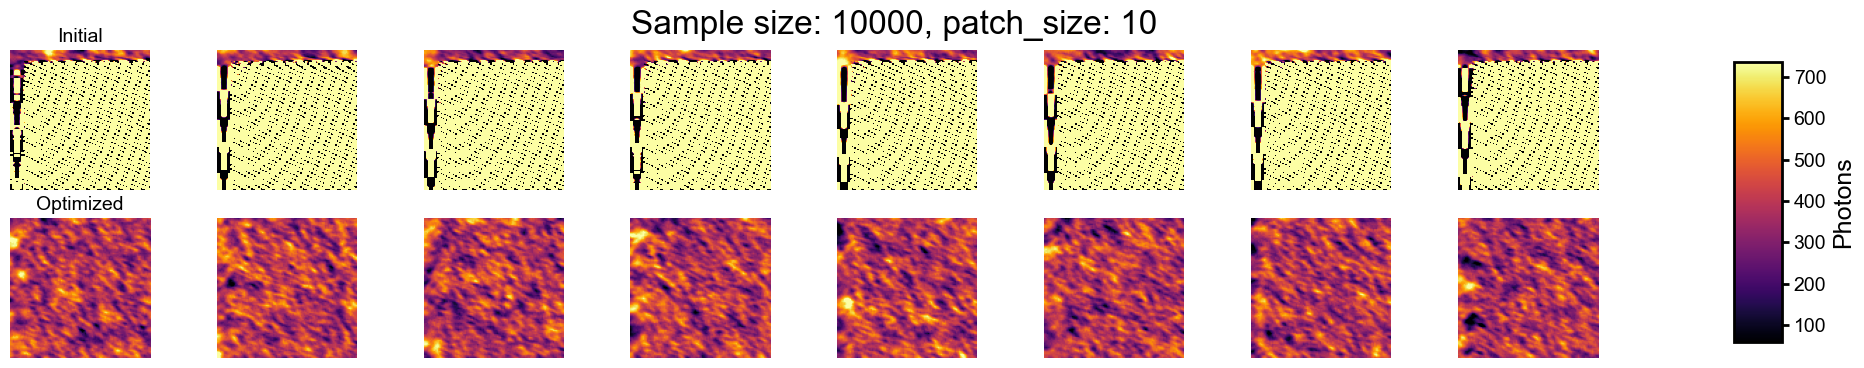

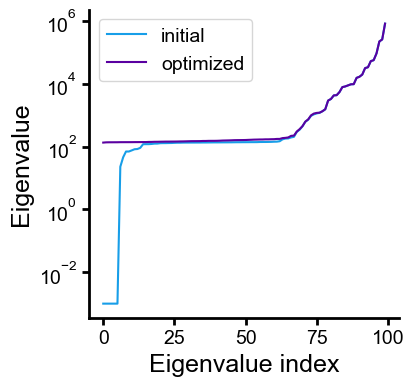

In [30]:
plot_and_print_analysis(nll_initial, nll_optimized,
                            samples_initial, samples_optimized,
                            cov_mat_initial, cov_mat_optimized, patch_size, num_samples)